In [1]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import datetime
import requests
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]
import networkx as nx #graphs
cwd = os.getcwd()

import seaborn as sns
import matplotlib.pyplot as plt

local imports

In [2]:
from ExMAS.utils import inData as inData
from dotmap import DotMap
from main import make_query, parse_OTP_response
from utils import plot
from utils import get_config
from datetime import timedelta
from scipy import optimize

# 1 mode: Walk + PT

## 1.1 OTP (OD) for ALL PT users

In [3]:
PATH = 'georequests_O(area0)_D.csv'
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = get_config('data/default_SUM.json')
df = pd.read_csv(PATH)
df['treq'] = pd.to_datetime(df.treq)
df1 = df.filter(['origin_x','origin_y','destination_x', 'destination_y', 'treq'], axis = 1)
df_PT_OD = df1.apply(lambda row: 
                 parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1) #query OTP for each request

def PT_utility(requests, params):
    if 'walkDistance' in requests.columns:
        
        # params.ticket_price = 0.7
        # params.wait_factor = 2
        requests = requests
        requests['PT_fare'] = 1 + requests.transitTime * params.avg_speed/1000 * params.ticket_price
        requests['u_PT'] = requests['PT_fare'] + \
                           params.VoT * (params.walk_factor * requests.walkDistance / params.speeds.walk +
                                           params.wait_factor * requests.waitingTime +
                                           params.transfer_penalty * requests.transfers + requests.transitTime)
    return requests

for name in list(df_PT_OD[0].keys()):
    vals = []
    for i in range(len(df_PT_OD)):
        if df_PT_OD[i]['success'] == True:
            vals.append(df_PT_OD[i][name])
        else:
            vals.append(None)
    df1[name] = vals
    
reqs_PT_OD = PT_utility(df1, params)

# 2 mode: NSM

## 2.1 ExMAS (OH) for ALL PT users

In [4]:
df = df1.filter(['origin_x','origin_y','destination_x', 'destination_y', 'treq'], axis = 1)
params = ExMAS.utils.get_config('data/default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [5]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['origin_y'], row['origin_x'])), axis = 1)
    # sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1) # in case of O-D by PT
    if type(sample['treq'][0]) == str:
        sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests 
    inData.requests = sample
    
    
    my_requests = inData.requests
    my_requests['destination'] = hub[1] 
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests['pax_id'] = list(range(len(my_requests)))
    
       
    inData.requests = my_requests
    # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
    inData = ExMAS.main(inData, params)
    schedule = inData.ExMAS.schedule
    requests = inData.ExMAS.requests
   
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    # KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     
   
    return KPIs, schedule, requests

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 8 
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844,19.88948]))]#

for frac in  [1]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 1 1
23-05-24 15:21:25-INFO-Initializing pairwise trip shareability between 166 and 166 trips.
23-05-24 15:21:25-INFO-creating combinations
23-05-24 15:21:25-INFO-27390	 nR*(nR-1)
23-05-24 15:21:25-INFO-Reduction of feasible pairs by 99.47%
23-05-24 15:21:25-INFO-Degree 2 	Completed
23-05-24 15:21:25-INFO-trips to extend at degree 2 : 314
23-05-24 15:21:25-INFO-At degree 2 feasible extensions found out of 8 searched
23-05-24 15:21:25-INFO-Degree 3 	Completed
23-05-24 15:21:25-INFO-trips to extend at degree 3 : 8
23-05-24 15:21:25-INFO-At degree 3 feasible extensions found out of 0 searched
23-05-24 15:21:25-INFO-Degree 4 	Completed
23-05-24 15:21:25-INFO-No more trips to exted at degree 4
23-05-24 15:21:25-INFO-Matching 166 trips to 488 rides in order to minimize u_veh
23-05-24 15:21:25-INFO-Problem solution: Optimal. 
Total costs for single trips:         46,885 
reduced by matching to:               32,579
23-05-24 15:21:25-INFO-Calculations  completed
23-05-24 15:21:25-INFO-DotM

In [6]:
df_SUM = df.copy()
df_SUM['index'] = inData.sblts.requests.index
df_SUM['hub'] = inData.sblts.requests.destination
df_SUM['ttrav'] = inData.sblts.requests.ttrav
df_SUM['tarr'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav, 's').floor('s'), axis=1)
df_SUM['u'] = inData.sblts.requests.u
df_SUM['ttrav_sh'] = inData.sblts.requests.ttrav_sh
df_SUM['tarr_sh'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav_sh, 's').floor('s'), axis=1)
df_SUM['u_sh'] = inData.sblts.requests.u_sh
# df_SUM.to_csv(f'res/ExMASrequests_OH_area10.csv')

## 2.2 OTP (HD) for ALL PT users

In [7]:
params.transfertime = 30 # transfertime for hub NSM-PT

df3 = df_SUM.rename(columns = {'treq': 'treq_origin'})
df3['origin_x'] = 19.88192 # hub1(8,9) coord_x
df3['origin_y'] = 50.08179 # hub1(8,9) coord_y
df3['treq'] = pd.to_datetime(df_SUM.tarr_sh) + timedelta(seconds=params.transfertime) # treq for PT

df_PT_HD = df3.apply(lambda row: 
                 parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1)
for name in list(df_PT_HD[0].keys()):
    vals = []
    for i in range(len(df_PT_HD)):
        if df_PT_HD[i]['success'] == True:
            vals.append(df_PT_HD[i][name])
        else:
            vals.append(None)
    df3[name] = vals
reqs_PT_HD = PT_utility(df3, params)

## 2.3 MODE CHOICE

In [8]:
ASC = -1.7350458516803646  # ASC for (8,9 (h1)+10)

df_SUM['u_SUM_OD'] = df_SUM.u_sh + reqs_PT_HD.u_PT + ASC
df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: -math.exp(df_SUM.u_SUM_OD), axis=1) / \
                     (df_SUM.apply(lambda df_SUM: -math.exp(df_SUM.u_SUM_OD), axis=1) +  \
                      reqs_PT_OD.apply(lambda reqs_PT_OD: -math.exp(reqs_PT_OD.u_PT), axis=1))
df_SUM.head(7)

,origin_x,origin_y,destination_x,destination_y,treq,index,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_SUM_OD,p_SUM
0,19.884686,50.017883,19.861117,50.006475,2024-03-28 07:57:59,0,1989392511,392,2024-03-28 08:04:31,4.9015,420.0,2024-03-28 08:04:59,4.827875,26.768077,1.000000e+00
1,19.872918,50.013853,19.890428,50.011478,2024-03-28 08:03:34,1,1989392511,145,2024-03-28 08:05:59,1.8170,145.0,2024-03-28 08:05:59,1.817000,20.283215,9.999901e-01
2,19.877280,50.017153,19.915984,50.031339,2024-03-28 08:08:47,2,1989392511,300,2024-03-28 08:13:47,3.7575,315.0,2024-03-28 08:14:02,3.719825,17.076005,9.989305e-01
3,19.869549,50.016558,19.906643,50.030131,2024-03-28 07:46:25,3,1989392511,188,2024-03-28 07:49:33,2.3560,203.0,2024-03-28 07:49:48,2.345750,16.610683,9.922274e-01
4,19.871897,50.004773,19.925828,50.075653,2024-03-28 08:11:57,4,1989392511,254,2024-03-28 08:16:11,3.1765,269.0,2024-03-28 08:16:26,3.154050,9.705713,3.479834e-06
5,19.882903,50.020074,19.763054,50.119087,2024-03-28 08:08:59,5,1989392511,311,2024-03-28 08:14:10,3.8905,325.0,2024-03-28 08:14:24,3.868225,17.110457,4.401374e-10
6,19.863420,50.016642,19.902171,50.010186,2024-03-28 08:06:37,6,1989392511,334,2024-03-28 08:12:11,4.1810,334.0,2024-03-28 08:12:11,4.181000,19.512369,9.996407e-01


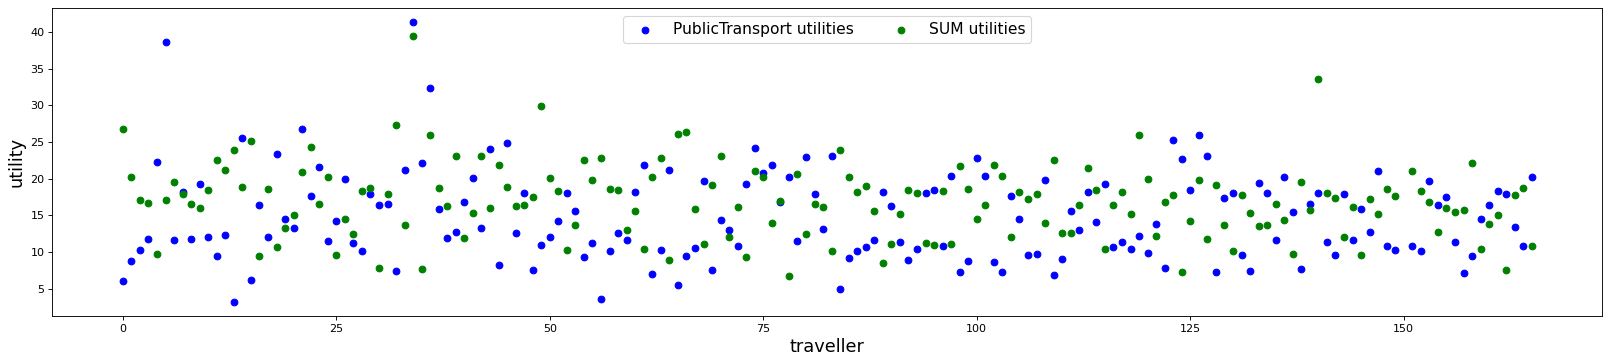

In [9]:
plt.figure(figsize=(25, 5), dpi=80)
u_PT_OD = plt.scatter(x = reqs_PT_OD.index, y = reqs_PT_OD.u_PT, color='blue')
u_SUM_OD = plt.scatter(x = df_SUM.index, y = df_SUM.u_SUM_OD, color='green')
# u_PrT = plt.scatter(x = df_SUM.index, y = df_PrT_OD.u_PrT, color='red')

plt.legend((u_PT_OD, u_SUM_OD), # , u_PrT
           ('PublicTransport utilities', 'SUM utilities'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=14)
plt.xlabel('traveller', fontsize=16)
plt.ylabel('utility', fontsize=16)
plt.show()

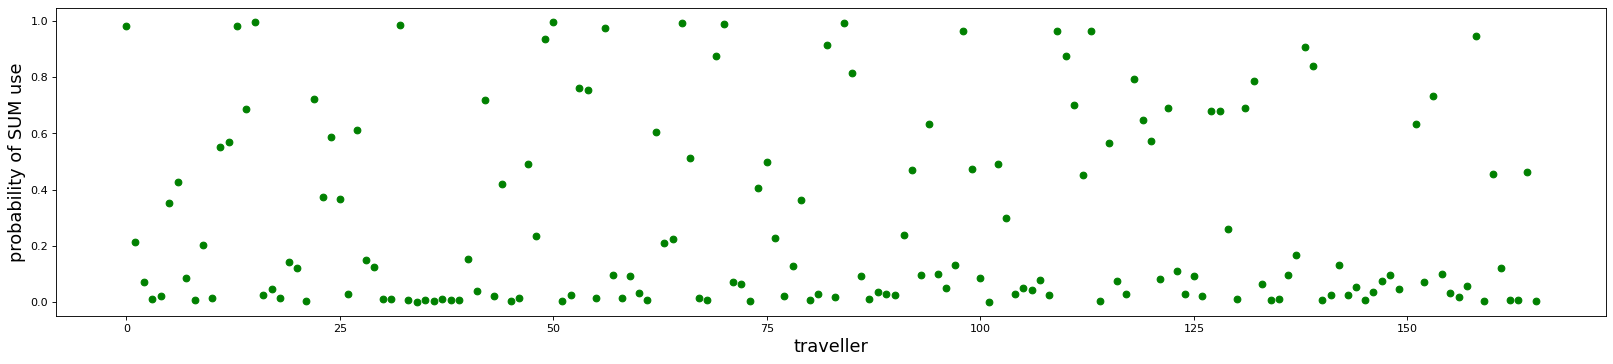

In [130]:
plt.figure(figsize=(25, 5), dpi=80)
p_SUM = plt.scatter(x = df_SUM.index, y = df_SUM.p_SUM, color='green')
# u_PrT = plt.scatter(x = df_SUM.index, y = df_PrT_OD.u_PrT, color='red')
plt.xlabel('traveller', fontsize=16)
plt.ylabel('probability of SUM use', fontsize=16)
plt.show()

## 2.4 DEMAND FOR SUM

In [131]:
# ts = []
# for i in range(len(df_SUM)):
#     if df_SUM.p_SUM[i] > 0.5:
#         ts.append(1)
#     else:
#         ts.append(0)

In [132]:
# df_SUM['t'] = ts 
# df_SUM.sample(3)

In [10]:
tr = []
for i in range(len(df_SUM)):
    r = random.random()
    if r < df_SUM.p_SUM[i]:
        tr.append(1)
    else:
        tr.append(0)

In [11]:
df_SUM['r'] = tr 
# df_SUM.sample(10)
demand_SUM = df_SUM[df_SUM.r == 1]
demand_PT = df_SUM[df_SUM.r != 1]


In [12]:
frac_SUM = len(demand_SUM) /len(df_SUM)
frac_SUM

0.572289156626506

In [13]:
df_SUM.p_SUM.mean()

0.5706748361062555

In [14]:
sum(df_SUM.r)

95

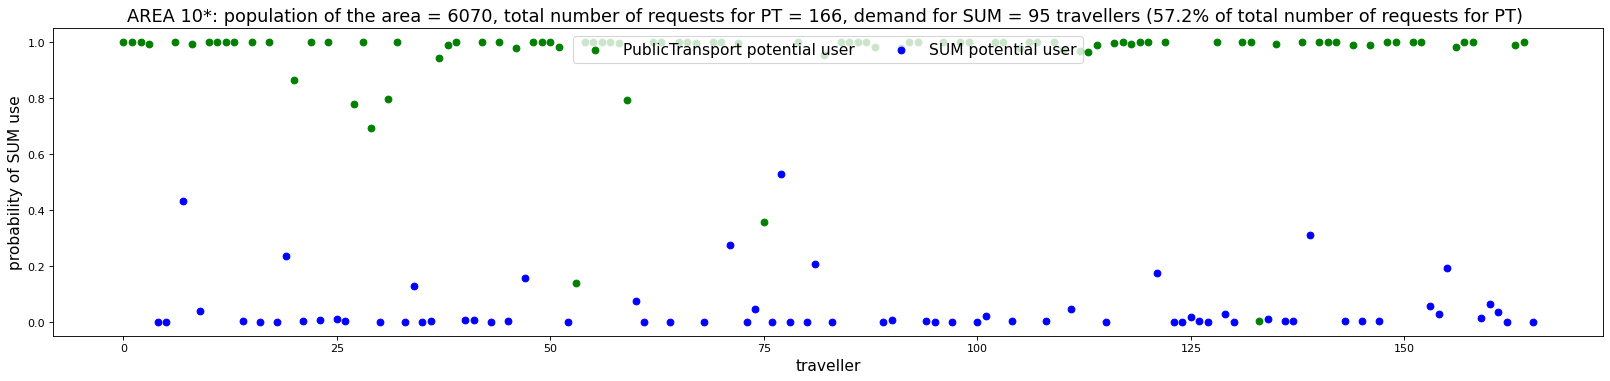

In [15]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = demand_SUM.index, y = demand_SUM.p_SUM, color='green')
plt.scatter(x = demand_PT.index, y = demand_PT.p_SUM, color='blue')
# plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=14)
plt.ylabel('probability of SUM use', fontsize=14)
plt.title(f'AREA 10*: population of the area = 6070, total number of requests for PT = {len(df_SUM) }, demand for SUM = {len(demand_SUM)} travellers ({round(frac_SUM * 100, 1)}% of total number of requests for PT) ', fontsize=16)
plt.legend(('PublicTransport potential user', 'SUM potential user'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=14)

plt.show()

# plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

### * count a number of travellers with p_SUM > 0.5

In [16]:
demand_SUM = df_SUM[df_SUM.p_SUM > 0.5]  ## nested logit model
demand_PT = df_SUM[df_SUM.p_SUM < 0.5]
frac_SUM = len(demand_SUM) /len(df_SUM)
frac_SUM

0.5602409638554217

In [17]:
# df_SUM[df_SUM.t != 1].to_csv(f'res/SUM chose_area10.csv')

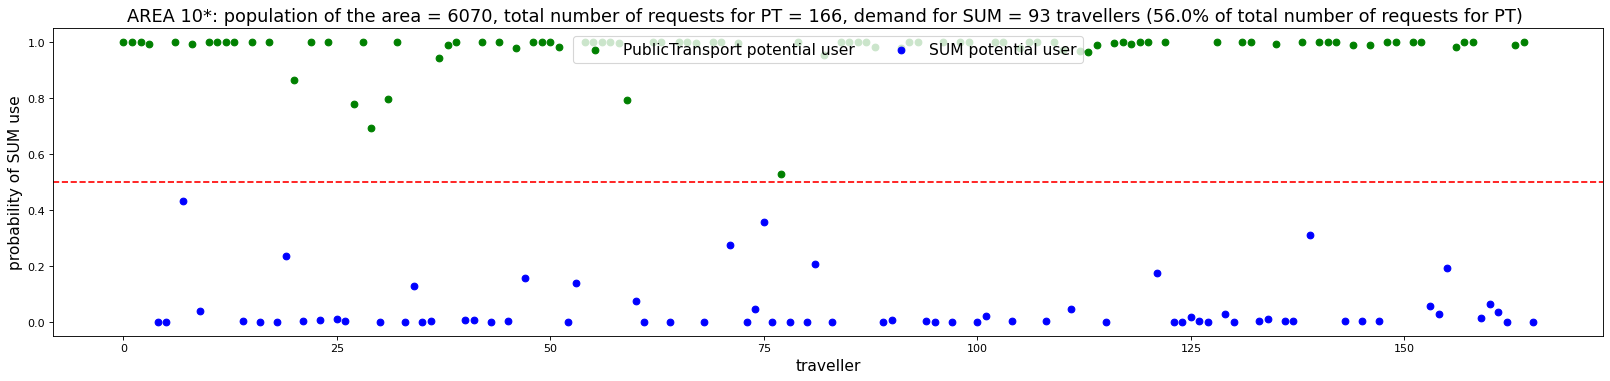

In [18]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = demand_SUM.index, y = demand_SUM.p_SUM, color='green')
plt.scatter(x = demand_PT.index, y = demand_PT.p_SUM, color='blue')
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=14)
plt.ylabel('probability of SUM use', fontsize=14)
plt.title(f'AREA 10*: population of the area = 6070, total number of requests for PT = {len(df_SUM) }, demand for SUM = {len(demand_SUM)} travellers ({round(frac_SUM * 100, 1)}% of total number of requests for PT) ', fontsize=16)
plt.legend(('PublicTransport potential user', 'SUM potential user'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=14)

plt.show()

# plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

In [19]:
demand_SUM = df_SUM[df_SUM.p_SUM > 0.5]
demand_PT = df_SUM[df_SUM.p_SUM < 0.5]
frac_SUM = len(demand_SUM) /len(df_SUM)
frac_SUM

0.5602409638554217

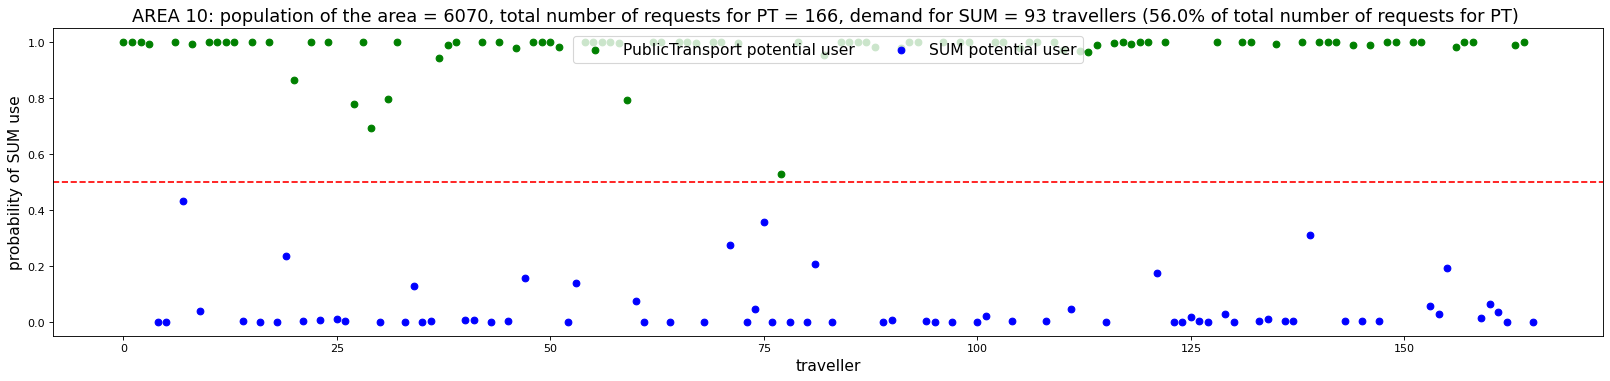

In [20]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = demand_SUM.index, y = demand_SUM.p_SUM, color='green')
plt.scatter(x = demand_PT.index, y = demand_PT.p_SUM, color='blue')
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=14)
plt.ylabel('probability of SUM use', fontsize=14)
plt.title(f'AREA 10: population of the area = 6070, total number of requests for PT = {len(df_SUM) }, demand for SUM = {len(demand_SUM)} travellers ({round(frac_SUM * 100, 1)}% of total number of requests for PT) ', fontsize=16)
plt.legend(('PublicTransport potential user', 'SUM potential user'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=14)

plt.show()

# plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

## ExMAS (OH) for SUM users

In [21]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['origin_y'], row['origin_x'])), axis = 1)
    # sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1) # in case of O-D by PT
    if type(sample['treq'][0]) == str:
        sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests 
    inData.requests = sample
    
    
    my_requests = inData.requests
    my_requests['destination'] = hub[1] 
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests['pax_id'] = list(range(len(my_requests)))
    
       
    inData.requests = my_requests
    # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
    inData = ExMAS.main(inData, params)
    schedule = inData.ExMAS.schedule
    requests = inData.ExMAS.requests
   
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    # KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     
   
    return KPIs, schedule, requests

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 8 
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844,19.88948]))]#

for frac in  [0.6]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(5): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 0.6 1
23-05-24 15:23:26-INFO-Initializing pairwise trip shareability between 99 and 99 trips.
23-05-24 15:23:26-INFO-creating combinations
23-05-24 15:23:26-INFO-9702	 nR*(nR-1)
23-05-24 15:23:26-INFO-Reduction of feasible pairs by 99.47%
23-05-24 15:23:26-INFO-Degree 2 	Completed
23-05-24 15:23:26-INFO-trips to extend at degree 2 : 115
23-05-24 15:23:26-INFO-At degree 2 feasible extensions found out of 3 searched
23-05-24 15:23:26-INFO-Degree 3 	Completed
23-05-24 15:23:26-INFO-trips to extend at degree 3 : 3
23-05-24 15:23:26-INFO-At degree 3 feasible extensions found out of 0 searched
23-05-24 15:23:26-INFO-Degree 4 	Completed
23-05-24 15:23:26-INFO-No more trips to exted at degree 4
23-05-24 15:23:26-INFO-Matching 99 trips to 217 rides in order to minimize u_veh
23-05-24 15:23:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,498 
reduced by matching to:               20,564
23-05-24 15:23:26-INFO-Calculations  completed
23-05-24 15:23:26-INFO-DotMap

KeyError: 0

In [ ]:
df

In [ ]:
type(df.treq[10])

## len(df)

In [112]:
results = {}
for num, frac, rep in list(itertools.product([1], [frac_SUM], range(11))):
    results[str((num, frac, rep))] = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/10/result10_(11).csv')
# dfr.head()

In [113]:
pd.read_csv('res/10/result10_(11).csv', header=None).T.to_csv('res/10/resultT10_(11).csv', header=False, index=False)

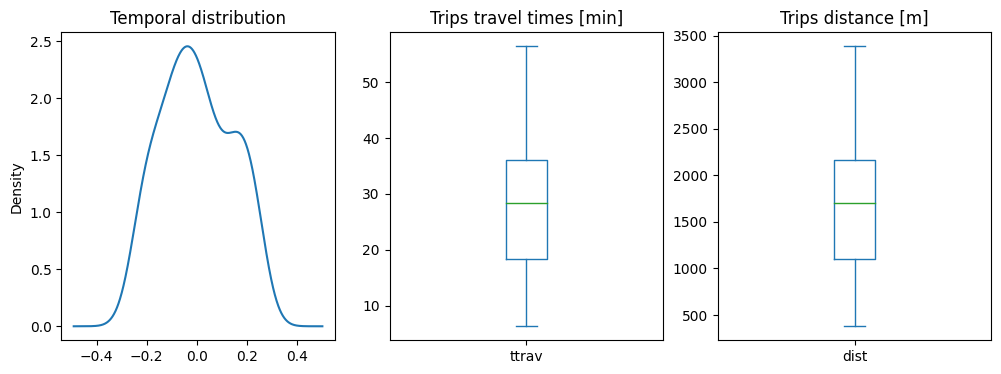

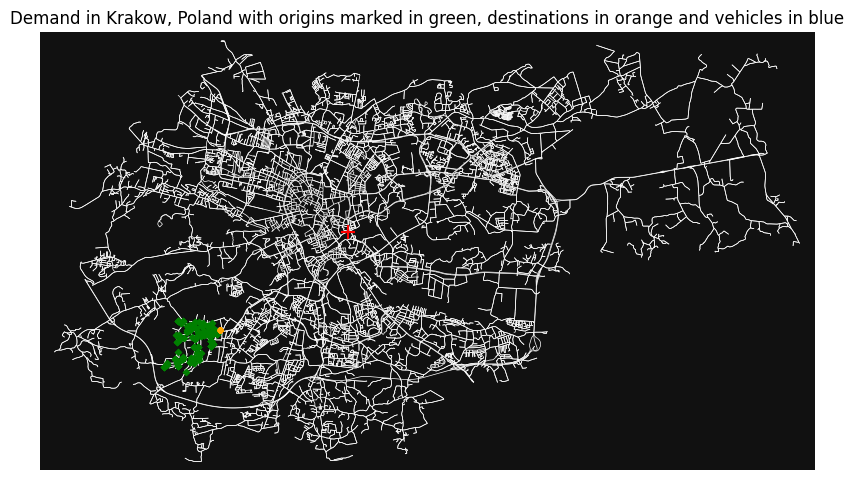

In [153]:
ExMAS.utils.plot_demand(inData, params)